In [2]:
import finterstellar as fs
import matplotlib.pyplot as plt

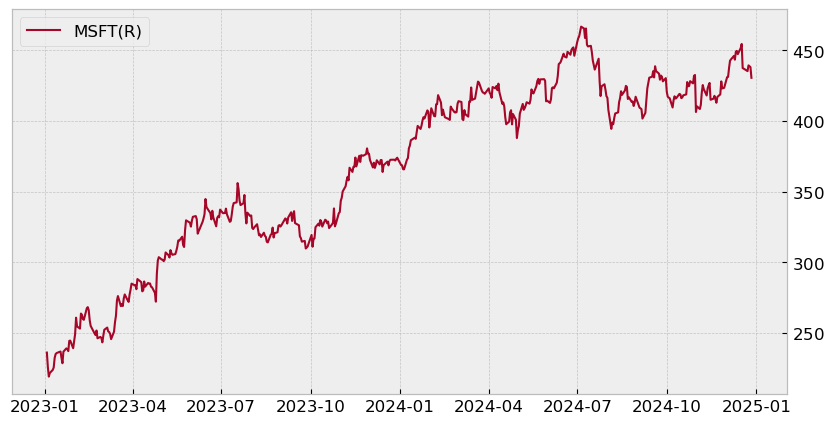

In [3]:
symbol = 'MSFT'
df_msft = fs.get_price(symbol, start_date="2023-01-01", end_date="2024-12-27")
fs.draw_chart(df_msft, right=symbol)

## MACD 전략

In [4]:
fs.macd(df_msft)

,MSFT,macd,macd_signal,macd_oscillator
2023-01-03,236.18,0.00,0.00,0.00
2023-01-04,225.85,-0.23,-0.13,-0.10
2023-01-05,219.16,-0.50,-0.28,-0.22
2023-01-06,221.74,-0.52,-0.36,-0.16
2023-01-09,223.90,-0.43,-0.38,-0.05
...,...,...,...,...
2024-12-20,436.60,5.25,6.17,-0.92
2024-12-23,435.25,4.40,5.81,-1.41
2024-12-24,439.33,4.00,5.45,-1.45
2024-12-26,438.11,3.55,5.07,-1.52


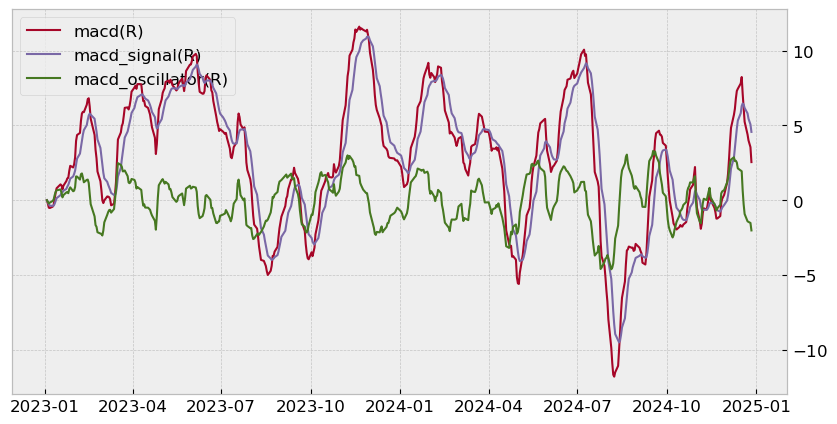

In [5]:
fs.draw_chart(df=df_msft, right = ['macd','macd_signal', 'macd_oscillator'])

In [6]:
fs.indicator_to_signal(df_msft, factor='macd_oscillator', buy=0, sell=0)

2023-01-03    zero
2023-01-04    zero
2023-01-05    zero
2023-01-06    zero
2023-01-09    zero
              ... 
2024-12-20    zero
2024-12-23    zero
2024-12-24    zero
2024-12-26    zero
2024-12-27    zero
Name: trade, Length: 500, dtype: object

In [7]:
df_msft

,MSFT,ema_short,ema_long,macd,macd_signal,macd_oscillator,trade
2023-01-03,236.18,236.18,236.18,0.00,0.00,0.00,zero
2023-01-04,225.85,230.58,230.82,-0.23,-0.13,-0.10,zero
2023-01-05,219.16,226.13,226.63,-0.50,-0.28,-0.22,zero
2023-01-06,221.74,224.74,225.26,-0.52,-0.36,-0.16,zero
2023-01-09,223.90,224.51,224.95,-0.43,-0.38,-0.05,zero
...,...,...,...,...,...,...,...
2024-12-20,436.60,441.10,435.85,5.25,6.17,-0.92,zero
2024-12-23,435.25,440.20,435.81,4.40,5.81,-1.41,zero
2024-12-24,439.33,440.07,436.07,4.00,5.45,-1.45,zero
2024-12-26,438.11,439.77,436.22,3.55,5.07,-1.52,zero


In [8]:
fs.position(df_msft)
df_msft

,MSFT,ema_short,ema_long,macd,macd_signal,macd_oscillator,trade,position,position_chart
2023-01-03,236.18,236.18,236.18,0.00,0.00,0.00,zero,,0
2023-01-04,225.85,230.58,230.82,-0.23,-0.13,-0.10,zero,zz,0
2023-01-05,219.16,226.13,226.63,-0.50,-0.28,-0.22,zero,zz,0
2023-01-06,221.74,224.74,225.26,-0.52,-0.36,-0.16,zero,zz,0
2023-01-09,223.90,224.51,224.95,-0.43,-0.38,-0.05,zero,zz,0
...,...,...,...,...,...,...,...,...,...
2024-12-20,436.60,441.10,435.85,5.25,6.17,-0.92,zero,zz,0
2024-12-23,435.25,440.20,435.81,4.40,5.81,-1.41,zero,zz,0
2024-12-24,439.33,440.07,436.07,4.00,5.45,-1.45,zero,zz,0
2024-12-26,438.11,439.77,436.22,3.55,5.07,-1.52,zero,zz,0


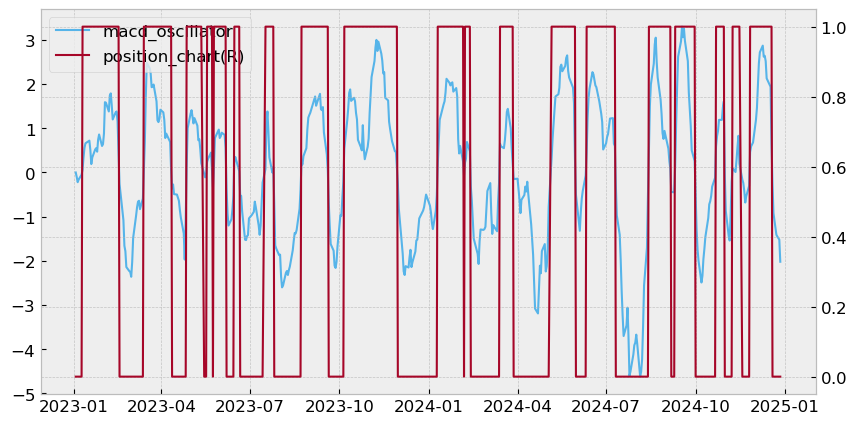

In [9]:
fs.draw_chart(df_msft, left='macd_oscillator',right='position_chart')

In [10]:
fs.evaluate(df_msft, cost=0.001)

,MSFT,ema_short,ema_long,macd,macd_signal,macd_oscillator,trade,position,position_chart,rtn,daily_rtn,acc_rtn,acc_rtn_dp,mdd,bm_mdd
2023-01-03,236.18,236.18,236.18,0.00,0.00,0.00,zero,,0,1.00,1.00,1.00,0.00,1.00,1.00
2023-01-04,225.85,230.58,230.82,-0.23,-0.13,-0.10,zero,zz,0,1.00,1.00,1.00,0.00,1.00,0.96
2023-01-05,219.16,226.13,226.63,-0.50,-0.28,-0.22,zero,zz,0,1.00,1.00,1.00,0.00,1.00,0.93
2023-01-06,221.74,224.74,225.26,-0.52,-0.36,-0.16,zero,zz,0,1.00,1.00,1.00,0.00,1.00,0.94
2023-01-09,223.90,224.51,224.95,-0.43,-0.38,-0.05,zero,zz,0,1.00,1.00,1.00,0.00,1.00,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-20,436.60,441.10,435.85,5.25,6.17,-0.92,zero,zz,0,1.00,1.00,1.30,29.78,0.91,0.94
2024-12-23,435.25,440.20,435.81,4.40,5.81,-1.41,zero,zz,0,1.00,1.00,1.30,29.78,0.91,0.93
2024-12-24,439.33,440.07,436.07,4.00,5.45,-1.45,zero,zz,0,1.00,1.00,1.30,29.78,0.91,0.94
2024-12-26,438.11,439.77,436.22,3.55,5.07,-1.52,zero,zz,0,1.00,1.00,1.30,29.78,0.91,0.94


In [11]:
fs.performance(df_msft, rf_rate=0.01)

CAGR: 14.04%
Accumulated return: 29.78%
Average return: 1.53%
Benchmark return : 82.29%
Number of trades: 19
Number of win: 9
Hit ratio: 47.37%
Investment period: 2.0yrs
Sharpe ratio: 0.64
MDD: -12.30%
Benchmark MDD: -15.49%


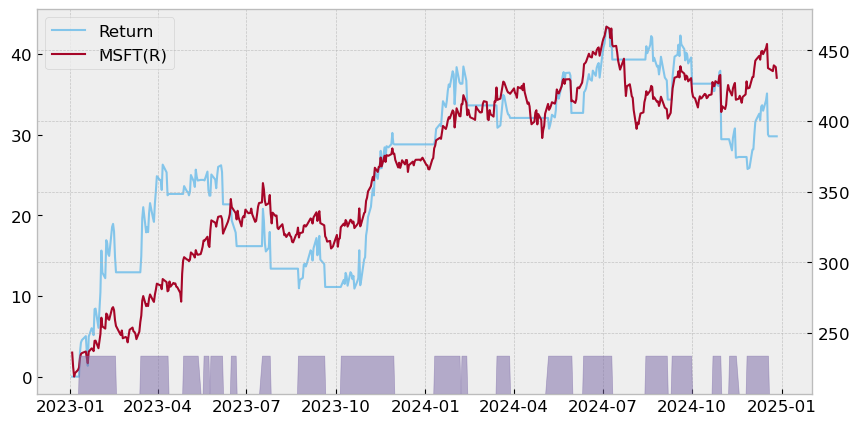

In [12]:
fs.draw_trade_results(df_msft)

## RSI 전략

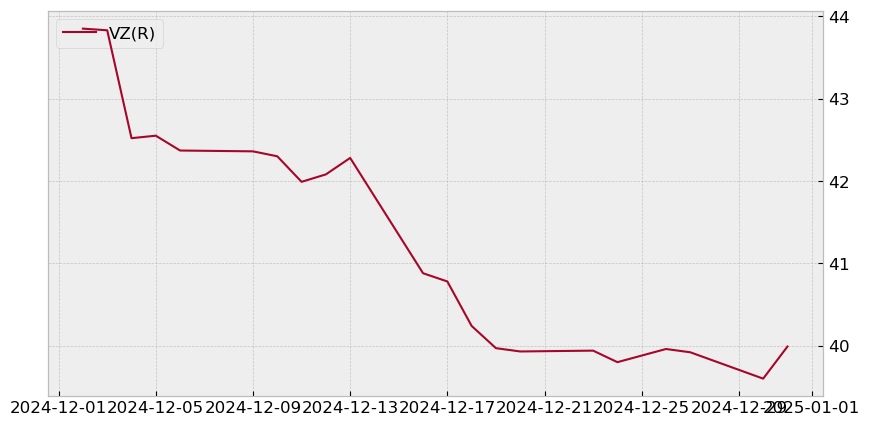

In [15]:
symbol = 'VZ'
df_vz = fs.get_price(symbol, start_date="2024-12-01", end_date="2024-12-31")
fs.draw_chart(df_vz, right=symbol)

In [16]:
fs.rsi(df_vz, w=14)
df_vz

,VZ,diff,au,ad,rsi
2024-12-02,43.85,NaN,NaN,NaN,NaN
2024-12-03,43.83,-0.02,NaN,NaN,NaN
2024-12-04,42.52,-1.31,NaN,NaN,NaN
2024-12-05,42.55,0.03,NaN,NaN,NaN
2024-12-06,42.37,-0.18,NaN,NaN,NaN
2024-12-09,42.36,-0.01,NaN,NaN,NaN
2024-12-10,42.30,-0.06,NaN,NaN,NaN
2024-12-11,41.99,-0.31,NaN,NaN,NaN
2024-12-12,42.08,0.09,NaN,NaN,NaN
2024-12-13,42.28,0.20,NaN,NaN,NaN


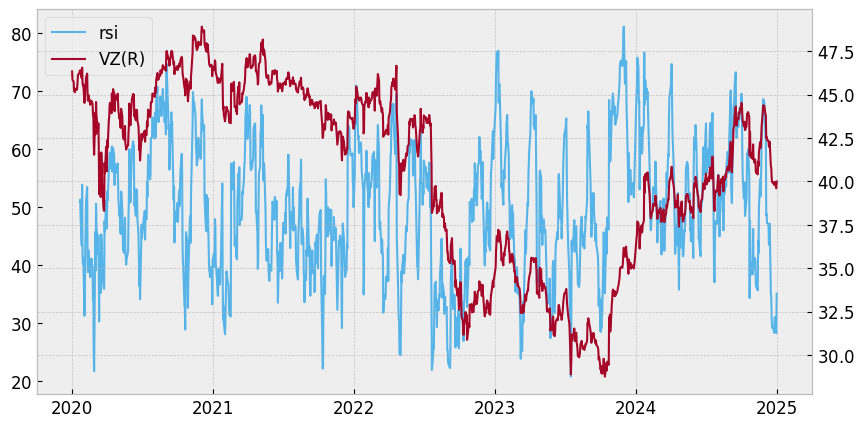

In [18]:
fs.draw_chart(df_vz, left='rsi', right=symbol)

In [19]:
fs.indicator_to_signal(df_vz, factor='rsi', buy=30, sell=70)
fs.position(df_vz)
df_vz

,VZ,diff,au,ad,rsi,trade,position,position_chart
2020-01-02,46.33,NaN,NaN,NaN,NaN,zero,,0
2020-01-03,45.84,-0.49,NaN,NaN,NaN,zero,zz,0
2020-01-06,45.74,-0.10,NaN,NaN,NaN,zero,zz,0
2020-01-07,45.23,-0.51,NaN,NaN,NaN,zero,zz,0
2020-01-08,45.32,0.09,NaN,NaN,NaN,zero,zz,0
...,...,...,...,...,...,...,...,...
2024-12-24,39.80,-0.14,0.09,0.22,28.28,buy,ll,1
2024-12-26,39.96,0.16,0.09,0.21,30.99,buy,ll,1
2024-12-27,39.92,-0.04,0.09,0.20,30.68,buy,ll,1
2024-12-30,39.60,-0.32,0.08,0.20,28.22,buy,ll,1


In [20]:
fs.evaluate(df_vz, cost=0.001)

,VZ,diff,au,ad,rsi,trade,position,position_chart,rtn,daily_rtn,acc_rtn,acc_rtn_dp,mdd,bm_mdd
2020-01-02,46.33,NaN,NaN,NaN,NaN,zero,,0,1.00,1.00,1.00,0.00,1.00,1.00
2020-01-03,45.84,-0.49,NaN,NaN,NaN,zero,zz,0,1.00,1.00,1.00,0.00,1.00,0.99
2020-01-06,45.74,-0.10,NaN,NaN,NaN,zero,zz,0,1.00,1.00,1.00,0.00,1.00,0.99
2020-01-07,45.23,-0.51,NaN,NaN,NaN,zero,zz,0,1.00,1.00,1.00,0.00,1.00,0.98
2020-01-08,45.32,0.09,NaN,NaN,NaN,zero,zz,0,1.00,1.00,1.00,0.00,1.00,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,39.80,-0.14,0.09,0.22,28.28,buy,ll,1,1.00,1.00,1.04,3.93,0.84,0.81
2024-12-26,39.96,0.16,0.09,0.21,30.99,buy,ll,1,1.00,1.00,1.04,4.35,0.84,0.82
2024-12-27,39.92,-0.04,0.09,0.20,30.68,buy,ll,1,1.00,1.00,1.04,4.24,0.84,0.82
2024-12-30,39.60,-0.32,0.08,0.20,28.22,buy,ll,1,1.00,0.99,1.03,3.41,0.83,0.81


In [21]:
fs.performance(df_vz, rf_rate=0.01)

CAGR: 0.88%
Accumulated return: 4.43%
Average return: 1.29%
Benchmark return : -13.78%
Number of trades: 5
Number of win: 3
Hit ratio: 60.00%
Investment period: 4.9yrs
Sharpe ratio: -0.01
MDD: -30.13%
Benchmark MDD: -41.22%


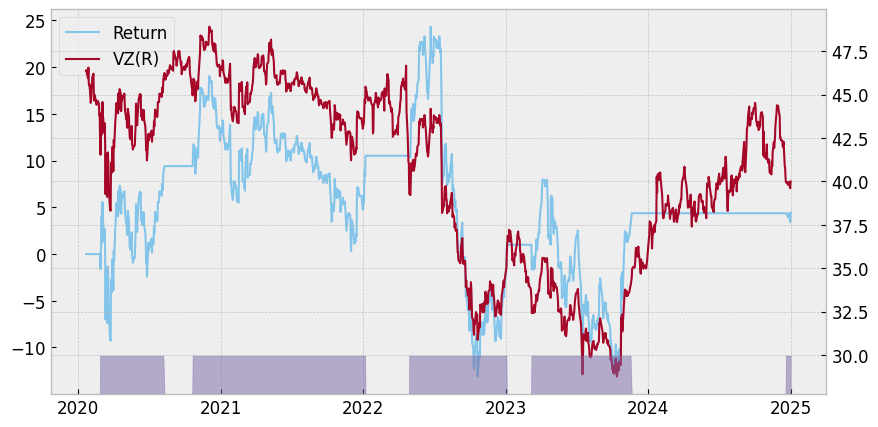

In [22]:
fs.draw_trade_results(df_vz)

In [24]:
fs.indicator_to_signal(df_vz, factor='rsi', buy=70, sell=50)
fs.position(df_vz)
df_vz

,VZ,diff,au,ad,rsi,trade,position,position_chart,rtn,daily_rtn,acc_rtn,acc_rtn_dp,mdd,bm_mdd,exs_rtn_daily
2020-01-22,46.38,0.12,0.10,0.10,50.89,zero,,0,1.00,1.00,1.00,0.00,1.00,1.00,-0.00
2020-01-23,46.40,0.02,0.10,0.10,51.24,zero,zz,0,1.00,1.00,1.00,0.00,1.00,1.00,-0.00
2020-01-24,46.23,-0.17,0.10,0.10,48.12,zero,zz,0,1.00,1.00,1.00,0.00,1.00,1.00,-0.00
2020-01-27,45.94,-0.29,0.09,0.12,43.29,zero,zz,0,1.00,1.00,1.00,0.00,1.00,0.99,-0.00
2020-01-28,46.55,0.61,0.13,0.11,53.80,zero,zz,0,1.00,1.00,1.00,0.00,1.00,1.00,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,39.80,-0.14,0.09,0.22,28.28,zero,zz,0,1.00,1.00,1.04,3.93,0.84,0.81,-0.00
2024-12-26,39.96,0.16,0.09,0.21,30.99,zero,zz,0,1.00,1.00,1.04,4.35,0.84,0.82,0.00
2024-12-27,39.92,-0.04,0.09,0.20,30.68,zero,zz,0,1.00,1.00,1.04,4.24,0.84,0.82,-0.00
2024-12-30,39.60,-0.32,0.08,0.20,28.22,zero,zz,0,1.00,0.99,1.03,3.41,0.83,0.81,-0.01


In [25]:
fs.evaluate(df_vz, cost=0.001)
fs.performance(df_vz, rf_rate=0.01)

CAGR: -0.10%
Accumulated return: -0.51%
Average return: 0.05%
Benchmark return : -13.78%
Number of trades: 6
Number of win: 2
Hit ratio: 33.33%
Investment period: 4.9yrs
Sharpe ratio: -0.13
MDD: -13.26%
Benchmark MDD: -41.22%


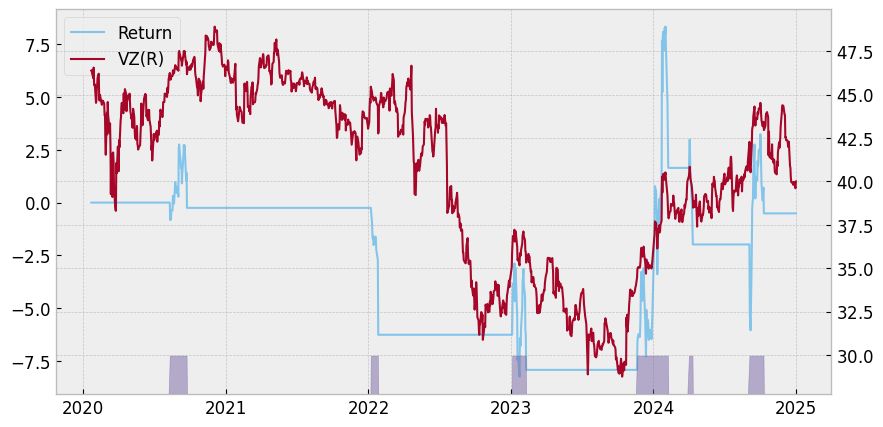

In [26]:
fs.draw_trade_results(df_vz)